In [169]:
from ipynb.fs.full.UtilFunctions import *

## 1.0 Get Data and Greet Data

1. A dataset should be broken up into multiple datasets:
    - data_raw = first read in of our data, but will not be touched
    - data_copy = data_raw copied, which will be used to clean, feature engineer, and wrangle our data
    <br><br>

2. Call [.info](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) to get an idea of how many entries, non-null counts, and the data type of each object
    <br><br>

3. Call [.sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to get a random sample of the data so we know what the data looks like
    <br><br>
  
4. Make sure that each image has 5 comments

In [170]:
data_raw = pd.read_csv('/Volumes/ExternalDrive/flickr30k_images/results.csv', delimiter='|')
data_copy = pd.read_csv('/Volumes/ExternalDrive/flickr30k_images/results.csv', delimiter='|')

In [171]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   image_name       158915 non-null  object
 1    comment_number  158915 non-null  object
 2    comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [172]:
data_raw.sample(10)

,image_name,comment_number,comment
66717,3347798761.jpg,2,A person on a dirt bike soaring through the a...
128571,4968586851.jpg,1,Four ladies walking through a hallway at an A...
33888,2542037086.jpg,3,A young boy smiles at the bottom of the slide .
137676,5730444205.jpg,1,"Two woman , one wearing a blue striped shirt ..."
95550,4295263796.jpg,0,Male in poor area of the world using a bucket...
80486,3654338683.jpg,1,White dog running through a field of yellow f...
7136,1413956047.jpg,1,These three young men are standing on a mount...
132900,526847964.jpg,0,A man in a dark suit talks with a middle-aged...
60802,321365748.jpg,2,Three men are singing karaoke in a bar .
145134,6743911073.jpg,4,A bicyclist is in the mud walking their bicyc...


Our data is structured with three columns:

- image_name: which is the unique tag of the image
- comment_number: which is the specific comment number about the image
- comment: this is the actual comment left about the image <br>

We expect to see 5 comments per uniuqe image_id so let's make sure that is the case:

In [173]:
image_name_unique_vals = data_raw['image_name'].unique().tolist()
print("Total length of unique values: ", len(image_name_unique_vals))
print("Total length of data frame: ",  len(data_raw))
print("Total length of unique values * 5: ", len(image_name_unique_vals) * 5)

Total length of unique values:  31783
Total length of data frame:  158915
Total length of unique values * 5:  158915


## 2.0 The 4 C's of Data Cleaning: Correction, Completing, Creating, and Converting

In this stage, we will clean our data by:

1. Correcting values and outliers
    - Call [.describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) to get a summary of our data with important statistics
    - Call function **preprocess_columns(dataframe)**
        - This function removes whitespace from the column names 
    - Call function **strip_whitespace(dataframe, column_name)**
        - We will use this to find why we have a null value and to make sure that we only have 5 comments per image
    - Call [.isNull()](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) to get a sum of all the nulls per each column
        - Once we find this out we call function **clean_null(dataframe)** to take care of the null value
    - Call function **expand_contractions**
        - Since we want to make it as easy as possible for the model to understand what is going on, we will get rid of all contractions
    - Call function **remove_punctuations**
        - Removes all punctuations from each comment
    - Call function **to_lower**
        - Convert every word to lower case
    - Use [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) to count the most used words
    - Use [NLTK.stopwords()](https://www.nltk.org/howto.html) to remove stopwords from each comment
        - Examples of stopwords are “a”, “the”, “is”, “are"\
    - Use Counter again to recompute the most used words per sentence
        <br><br>
2. Completing missing information
    - **Note:** this is not needed as we took care of the null value in the correcting value section
        <br><br>
3. Creating new features for analysis (**Feature Engineering**)
    - Call function **classify_images(dataframe, column_name, new_column_name)**
        - This function will create a new column that labels each image
        - This is needed to pass into our model later on
    - Call function **count_words**
        - Creates a new column of the total words per comment
    - Call function **count_unique_words**
        - Creates a new column of unique words in each comment
    - Create a new column of the ratio between unique words and non-unique words
        <br><br>
4. converting fields to the correct format for calculations and presentation
    - **Note:** this is not needed, we will format later on as we turn our dataframe into tensors

**Note** these functions are in the UtilFunctions notebook

## 2.1 Correcting data

In [174]:
data_copy.describe(include='all').transpose()

,count,unique,top,freq
image_name,158915,31783,1000092795.jpg,5
comment_number,158915,6,0,31783
comment,158914,158438,Two dogs playing in the snow .,7


**Clean the column names:**

In [175]:
print("Before cleaning: ", data_copy.columns)
preprocess_columns(data_copy)
print("After cleaning: ", data_copy.columns)

Before cleaning:  Index(['image_name', ' comment_number', ' comment'], dtype='object')
After cleaning:  Index(['image_name', 'comment_number', 'comment'], dtype='object')


**Clean the comment number values:**
- We are supposed to only have 5 comments per image, but we have 6 unique values

In [176]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print("Before cleaning: ", comment_number_unique_vals)
data_copy = strip_whitespace(data_copy, 'comment_number')
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print("After cleaning: ", comment_number_unique_vals)

Before cleaning:  [' 0', ' 1', ' 2', ' 3', ' 4', ' 4   A dog runs across the grass .']
After cleaning:  ['0', '1', '2', '3', '4', '4Adogrunsacrossthegrass.']


**Taking care of 4Adogrunsacrossthegrass issue as it looks like a comment number and sentence was combined accidentally**

In [177]:
print('Columns with null values before cleaning:')
print(data_copy.isnull().sum())
clean_null(data_copy)
print('Columns with null values after cleaning:')
print(data_copy.isnull().sum())

Columns with null values before cleaning:
image_name        0
comment_number    0
comment           1
dtype: int64
Columns with null values after cleaning:
image_name        0
comment_number    0
comment           0
dtype: int64


 **Make a new column that will hold our cleaned data for each comment:**

In [178]:
data_copy['cleaned_comment'] = data_copy['comment']

In [179]:
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(expand_contractions)

In [180]:
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(remove_punctuations)

In [181]:
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(to_lower)

In [182]:
data_copy.sample(1)

,image_name,comment_number,comment,cleaned_comment
25847,2350646648.jpg,2,Poor family sitting next to the emergency win...,poor family sitting next to the emergency win...


In [183]:
Counter(" ".join(data_copy["cleaned_comment"]).split()).most_common(15)

[('a', 271704),
 ('in', 83466),
 ('the', 62981),
 ('on', 45669),
 ('and', 44263),
 ('man', 42598),
 ('is', 41146),
 ('of', 38779),
 ('with', 36207),
 ('woman', 22211),
 ('two', 21642),
 ('are', 20211),
 ('to', 17609),
 ('people', 17337),
 ('at', 16259)]

In [184]:
stop = stopwords.words('english') #assign all stopwords to variable stop
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #remove stopwor

In [185]:
Counter(" ".join(data_copy["cleaned_comment"]).split()).most_common(15)

[('man', 42598),
 ('woman', 22211),
 ('two', 21642),
 ('people', 17337),
 ('wearing', 15709),
 ('young', 13218),
 ('white', 13178),
 ('shirt', 12981),
 ('black', 12311),
 ('blue', 11310),
 ('red', 9916),
 ('girl', 9655),
 ('sitting', 9620),
 ('men', 9498),
 ('boy', 9429)]

## 2.2 Feature Engineering

In [186]:
classify_images(data_copy, 'image_name', 'label')

In [187]:
data_copy['word_count'] = data_copy['comment'].apply(lambda x : count_words(x))
data_copy['unique_word_count'] = data_copy['comment'].apply(lambda x : count_unique_words(x))
data_copy['unique_words_vs_words'] = data_copy['unique_word_count']/data_copy['word_count']

In [188]:
data_copy.sample(1)

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words
19271,2178064851.jpg,1,A little kid is starring into a body of water .,little kid starring body water,3854,11,11,1.0


## 3.0 Prepping Model

1. Since the dataset is massive, I will slice it to the first 500 rows
    - We will scale up as our model improves
<br><br>

2. Tokenize our data using [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto)
    - `AutoTokenizer` always works and automatically chooses the correct class for the model you are using
        - The `AutoTokenizer` will use a pretrained bert model 'bert-base-uncased'
        - It will convert our data into a format that can be processed by the bert model
    - **BERT** expects inputIds and attention masks
        - `inputIds`: a mapping between tokens and their ids
            - Each word in the vector has a unique id, the input id maps this unique id to its token
            - We do this by creating a numpy array of 0's that takes in the size of the dataset and the sequence length to get our shape correct to match the dataset
            - **Sequence length:** is the max amount of words to consider when we tokenize
        - `attention mask`: depicts where the padding are in the comment
            - 1 indicates that the mask should perform an action
            - 0 indicates that it is a padding value and should be left alone
            - similar to `inputIds` we create a numpy array of 0's that takes in the size of the dataset and the sequence length to get our shape correct to match the dataset
<br><br>

3. Define sequence length, number of samples, and number of classes
    - **BERT** only takes up to 512 'sequences' so we define the length as so
    - **number of samples:** the length of the dataset
    - **number of classes:** the number of classifications we have to make
<br><br>

4. Call function **generate_Xids(num_samples, seq_len)**
    - This function creates a numpy array of shape(num_samples, seq_len)
    - Needed when we turn our data to tensors
<br><br>

5. Call function **generate_attn_masks(num_samples, seq_len)**
    - This function creates a numpy array of shape(num_samples, seq_len)
    - Needed when we turn our data to tensors
<br><br>

6. Call function **generate_encoded_values(dataframe, input, input, tokenizer, sequence_length)**
    - [encode_plus](https://huggingface.co/docs/transformers/v4.26.1/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus) will turn our comments into a matrix of integers
<br><br>

7. Create a label numpy array of shape(num_samples, num_classes) and one hot encode it
    - One hot encoding shows whether the label is present in that specific row
        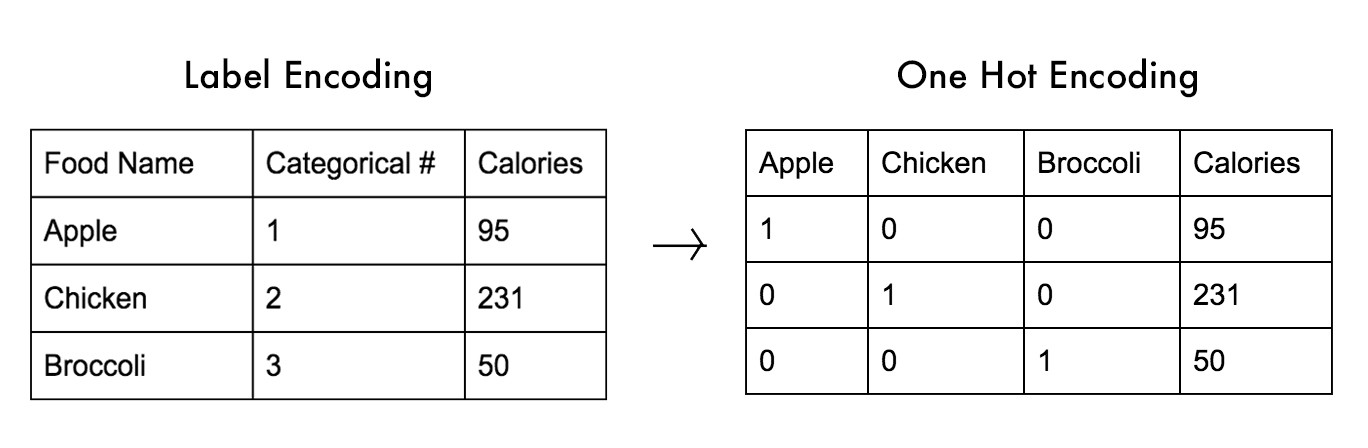
<br><br>

8. Turn dataset into tensors
    - Use [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
    - To inspect a random tensor use [tf.data.Dataset.take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)
    - You can loop through the dataset using [tf.data.Dataset.as_numpy_iterator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator)
<br><br>

9. Create function **mapping_inputIds_attention_masks_labels(input_ids, attention_masks, labels)** and convert our dataset
    - I tried to put this in the UtilFunctions notebook, but tensorflow had an issue with it
    - See cell below for documentation and how it works
<br><br>

10. Create train_dataset and val_dataset
    - Take a random sample
    - **Batch size:** represent the number of consecutive elements of this dataset to combine in a single batch
    - Call [.shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) with a shuffle size of 10,000 and call [.batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) to get the elements into a 'batch'
    - Take a random sample
    - Define split size
    - Define train size
        - For each batch we will have number of sample / batch_size
        - We will also take out the split_size which will serve as our train data
    - Define train_dataset
        - Call [.take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) to take the train size we defined above
    - Define val_dataset
        - Call [.skip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) to skip the train size
        - This is our test data

In [189]:
data_copy = data_copy[:500]

In [190]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [191]:
SEQUENCE_LENGTH = 512
NUM_SAMPLES = len(data_copy)
NUM_CLASSES = int(NUM_SAMPLES / 5)

In [192]:
Xids = generate_Xids(num_samples=NUM_SAMPLES, seq_len=SEQUENCE_LENGTH)

In [193]:
attn_masks = generate_attn_msks(num_samples=NUM_SAMPLES, seq_len=SEQUENCE_LENGTH)

In [194]:
Xids.shape, attn_masks.shape

((500, 512), (500, 512))

In [195]:
Xids, attn_masks = generate_encoded_values(data_copy, Xids, attn_masks, tokenizer, SEQUENCE_LENGTH)

0it [00:00, ?it/s]

In [196]:
Xids, attn_masks

(array([[ 101., 1960., 1685., ...,    0.,    0.,    0.],
        [ 101., 1960., 1685., ...,    0.,    0.,    0.],
        [ 101., 1960., 1441., ...,    0.,    0.,    0.],
        ...,
        [ 101.,  138., 1299., ...,    0.,    0.,    0.],
        [ 101., 1109., 1685., ...,    0.,    0.,    0.],
        [ 101.,  138., 1263., ...,    0.,    0.,    0.]]),
 array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]))

In [197]:
labels = np.zeros((NUM_SAMPLES, NUM_CLASSES))

In [198]:
labels.shape

(500, 100)

In [199]:
labels[np.arange(NUM_SAMPLES), data_copy['label'].values] = 1

In [200]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [201]:
data_copy_to_tensors = tf.data.Dataset.from_tensor_slices((Xids, attn_masks, labels)) #turn our data into tensors
data_copy_to_tensors.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(100,), dtype=tf.float64, name=None))>

In [202]:
def mapping_inputIds_attention_masks_labels(input_ids, attention_masks, labels):
    '''
        This function will convert our dataset to its required format by mapping our values
        
        args:
            input_ids: Xids
            attention_masks: attn_masks
            labels: labels
            
        return:
            inputs_ids, attention_masks, labels
    '''
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels

data_copy_to_tensors = data_copy_to_tensors.map(mapping_inputIds_attention_masks_labels)

In [203]:
data_copy_to_tensors.take(1) #take a random sample of the data

batch_size = 16
data_copy_to_tensors = data_copy_to_tensors.shuffle(10000).batch(batch_size, drop_remainder=True) #create a random seed for distribution

data_copy_to_tensors.take(1)

p = 0.8
train_size = int((NUM_SAMPLES // batch_size) * p) #for each batch we will have # of samples / batch_size and take out 80% of that to train with


train_dataset = data_copy_to_tensors.take(train_size) #create train dataset
val_dataset = data_copy_to_tensors.skip(train_size)   #create test dataset

In [204]:
train_dataset

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 100), dtype=tf.float64, name=None))>

In [205]:
val_dataset

<SkipDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 100), dtype=tf.float64, name=None))>

## 4.0 Building Model

1. Create pre-trained [BERT](https://huggingface.co/docs/transformers/main_classes/model) model
<br><br>

2. Create layers
    - We will use two [input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layers:
        1. input_ids
        2. attention masks
    - We will make an embedding layer
        - Encapsulates the meaning of the word from our input_ids and attention masks
        - Stack the inputs to get a '[pooler](https://github.com/google-research/bert/issues/1102) layer'  
    - Hidden layer
        - A [dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with [relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation and sequence_length * 2 neurons
        - Stack the embedding layer 
    - Output layer
        - Another [dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer that takes in the number of classes and a [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax) activation
        - Stack the hidden layer
<br><br>

3. Compile model
    - Use [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) to compile and get model summary
<br><br>

4. Create optimizer
    - We will use [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with an adjusted learning rate and decay
<br><br>
    
5. Create loss function
    - We will use [CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) to calculate our loss
<br><br>
    
6. Create metric
    - We will use [CategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy)
<br><br>
 
7. Create callback
    - We will use the [callback](https://keras.io/api/callbacks/) to monitor our loss function and stop training if our loss function does not keep decreasing after a set amount of epochs
<br><br>
 
8. Fit model and track history
   - Train over 50 epochs
   - **Important: WATCH OVERFITTING(model memorizes train data but does terrible on test data)**
       - If we deem that the model is overfitting we can use [regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)
       - We can also use a [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer

In [206]:
model = TFBertModel.from_pretrained('bert-base-cased') #instantiate model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [207]:
#we need two input layers, input_ids and attention_masks
input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), name='attention_mask', dtype='int32')

#embedding layer, serves as an pooled layer[1], can also change to an activation layer[0]
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#can create other hidden layers here too if needed

#hidden layer, creates a Dense layer with sequence_len * 2 neurons can change neurons and activations
hidden_layer = tf.keras.layers.Dense(SEQUENCE_LENGTH*2, activation='relu', name='hidden_layer')(bert_embds)


#output layer, takes in the number of classes for neurons, using softmax because is calculates probability of classes
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(hidden_layer) 

#build model
built_comment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
built_comment_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [208]:
#create optimizer, can change learning rate if needed 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=0.000001)
#create loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()
#create accuracy metrics
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",        #metric to monitor
                                        mode ="min",                #In min mode, training will stop when the value of data that is monitored stop decreasing.
                                        patience = 5,               #after 5 epochs of no decrease we stop 
                                        restore_best_weights = True #restore the best value
                                       )

built_comment_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy]) #compile model

#create model history
built_comment_model_history = built_comment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks =[earlystopping]
)

Epoch 1/50


2023-02-18 17:23:16.456437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 4.8023 - accuracy: 0.0156

2023-02-18 17:26:42.072614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 215s 9s/step - loss: 4.8023 - accuracy: 0.0156 - val_loss: 4.7308 - val_accuracy: 0.0179
Epoch 2/50
24/24 [==============================] - 193s 8s/step - loss: 4.6767 - accuracy: 0.0130 - val_loss: 4.6520 - val_accuracy: 0.0268
Epoch 3/50
24/24 [==============================] - 209s 9s/step - loss: 4.5816 - accuracy: 0.0208 - val_loss: 4.5087 - val_accuracy: 0.0357
Epoch 4/50
24/24 [==============================] - 210s 9s/step - loss: 4.5132 - accuracy: 0.0547 - val_loss: 4.3844 - val_accuracy: 0.1071
Epoch 5/50
24/24 [==============================] - 200s 8s/step - loss: 4.4304 - accuracy: 0.0729 - val_loss: 4.2630 - val_accuracy: 0.1071
Epoch 6/50
24/24 [==============================] - 198s 8s/step - loss: 4.3308 - accuracy: 0.1042 - val_loss: 4.1299 - val_accuracy: 0.1518
Epoch 7/50
24/24 [==============================] - 204s 8s/step - loss: 4.2015 - accuracy: 0.1198 - val_loss: 4.1609 - val_accuracy: 0.1250
Epoch 8/50
24/24 [======

## 5.0 Evaluating Model

1. Call **generate_train_loss_plots(num_epochs, model_name)**
    - Plots the loss function on train and validation
    - Plots the accuracy on train and validation

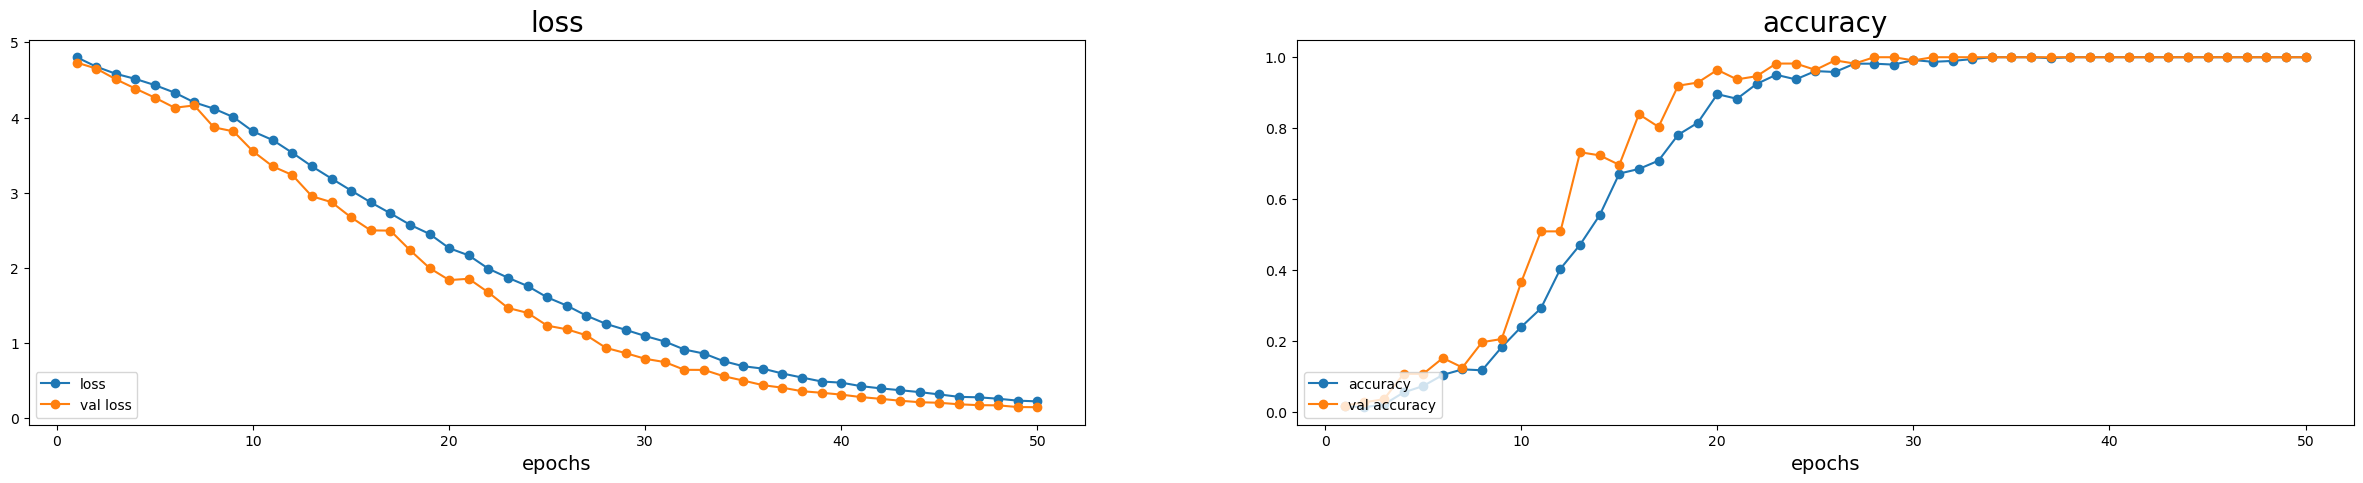

In [210]:
generate_train_loss_plots(50, built_comment_model_history)

## 6.0 Predictions For Sentence Model

1. Call **generate_num_classes(num_classes)**
    - Generates a list of all the labels for our prediction
<br><br>

2. Pick a random sample from the dataset
<br><br>

3. Create a string of text
<br><br>

4. Call **prepare_data(input, tokenizer, seq_len)**
    - This will encode the sentence that is inputted
<br><br>

5. Call **make_prediction(model_name, processed_data, classes)**
    - Makes a prediction about the given text
<br><br>

6. Print prediction

In [211]:
class_list = generate_num_classes(NUM_CLASSES)

In [222]:
data_copy.sample(1)

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words
206,1010470346.jpg,1,A man leans into a car to talk to the driver ...,man leans car talk driver man bicycle looks,41,21,16,0.761905


In [223]:
input_text = "man talking to driver"
processed_data = prepare_data(input_text, tokenizer, SEQUENCE_LENGTH)
result = make_prediction(built_comment_model, processed_data=processed_data, classes=class_list)
print(f"Predicted Label: {result}")

1/1 [==============================] - 0s 381ms/step
Predicted Label: 41


In [224]:
data_copy[data_copy['label']== 41]

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words
205,1010470346.jpg,0,two men in florescent vests are standing next...,two men florescent vests standing next parked ...,41,35,30,0.857143
206,1010470346.jpg,1,A man leans into a car to talk to the driver ...,man leans car talk driver man bicycle looks,41,21,16,0.761905
207,1010470346.jpg,2,A man on a bicycle watching a row of cars wai...,man bicycle watching row cars waiting go check...,41,17,15,0.882353
208,1010470346.jpg,3,A park ranger talking to a tourist .,park ranger talking tourist,41,8,8,1.000000
209,1010470346.jpg,4,Two cars are parked outside .,two cars parked outside,41,6,6,1.000000
